# Tesla Stock Price Prediction, 365 Days
### Second Semester Capstone

This is the same as the "Semester Start" notebook, but now I'm making a 365 day prediction. I've also added a section for finding the quarterly maximums and adding those maximums to the prediction chart.  This is a prediction of Tesla stock price. I've moved the data preprocessing to the separate dataPreprocessing notebook.

In [2]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot
from statistics import mean

# LSTM Application

## Preparing Data

In [3]:
# Loading Preprocessed Data File
df = pd.read_csv("Data/preprocessed.csv",parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)

print(df.shape)
df.head()

(2699, 20)


,Open,High,Low,Close,Adj Close,Volume,Musk Tweet Count,Musk Likes,Musk Replies,Musk Retweets,Musk Positive Sentiment,Musk Contains Tesla,Musk Negative Sentiment,Trump Tweet Count,Trump Favorites,Trump Retweets,Trump Positive Sentiment,Trump Contains Tesla,Trump Negative Sentiment,Tesla Trend
Date,,,,,,,,,,,,,,,,,,,,
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0,27.0,0.0,0.0,1.0,7.00
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,36.0,78.0,2.0,0.0,0.0,6.09
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,47.0,0.0,0.0,1.0,2.10
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.78
2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60


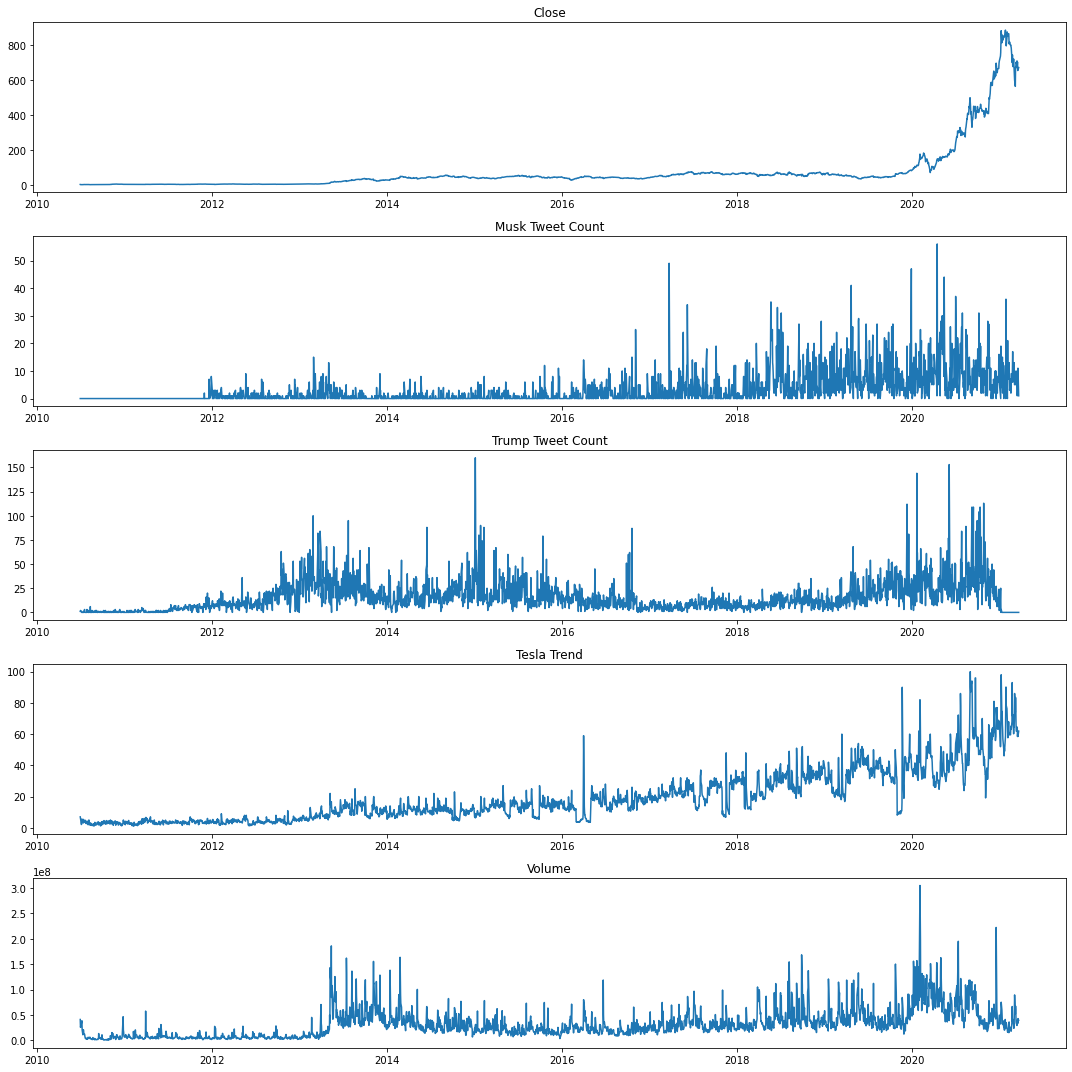

In [4]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(15,15))

pyplot.subplot(5,1,1)
pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")
pyplot.subplot(5,1,2)
pyplot.plot(dates, df["Musk Tweet Count"], label="Musk Tweet Count")
pyplot.title("Musk Tweet Count")
pyplot.subplot(5,1,3)
pyplot.plot(dates, df["Trump Tweet Count"], label="Trump Tweet Count")
pyplot.title("Trump Tweet Count")
pyplot.subplot(5,1,4)
pyplot.plot(dates, df["Tesla Trend"], label="Tesla Trend")
pyplot.title("Tesla Trend")
pyplot.subplot(5,1,5)
pyplot.plot(dates, df["Volume"], label="Volume")
pyplot.title("Volume")


pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [5]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Converting Data for Supervised Learning

In [10]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here since we don't have non-numerical data)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, 1, 1)

# Drop Columns of Variables We Aren't Predicting
# We want all variables we're including in the model for t-1 and only the variable we're predicting for time t
reframed.drop(reframed.loc[:, 'Adj Close(t)':'Tesla Trend(t)'], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Open(t)':'Low(t)'], axis=1, inplace=True)

print(reframed.shape)
reframed.head()

(2698, 21)


,Open(t-1),High(t-1),Low(t-1),Close(t-1),Adj Close(t-1),Volume(t-1),Musk Tweet Count(t-1),Musk Likes(t-1),Musk Replies(t-1),Musk Retweets(t-1),...,Musk Contains Tesla(t-1),Musk Negative Sentiment(t-1),Trump Tweet Count(t-1),Trump Favorites(t-1),Trump Retweets(t-1),Trump Positive Sentiment(t-1),Trump Contains Tesla(t-1),Trump Negative Sentiment(t-1),Tesla Trend(t-1),Close(t)
1,0.001995,0.002071,0.001218,0.001400,0.001400,0.133184,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00625,1.954631e-06,0.000011,0.000000,0.0,0.011236,0.060606,0.000773
2,0.001545,0.001442,0.000859,0.000773,0.000773,0.082560,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01250,4.397919e-06,0.000031,0.021053,0.0,0.000000,0.051414,0.000070
3,0.000869,0.000751,0.000196,0.000070,0.000070,0.110956,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00625,7.329866e-07,0.000019,0.000000,0.0,0.011236,0.011111,0.000000
4,0.000059,0.000000,0.000000,0.000000,0.000000,0.111857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.028081,0.000377
5,0.000000,0.000198,0.000136,0.000377,0.000377,0.124842,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.046465,0.000364


In [6]:
values = reframed.values
# split into train, test, and prediction sets
n_predict = 365 # We are predicting 365 days
n_train = floor(len(values) * 0.80) # 80% of the data is currently used for train (can be adjusted)
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :] # What's left is used for test
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(2158, 1, 20) (2158,) (175, 1, 20) (175,) (365, 1, 20) (365,)


## Running Model

In [7]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg
#from tensorflow.keras.callbacks import Callback

# Unused
"""
class stopAtLossValue(Callback):
        def on_batch_end(self, batch, logs={}):
            THR = 0.009 #Assign THR with the value at which you want to stop training.
            if logs.get('loss') <= THR:
                 self.model.stop_training = True
"""

2022-02-10 11:42:10.131605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 11:42:10.131695: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


"\nclass stopAtLossValue(Callback):\n        def on_batch_end(self, batch, logs={}):\n            THR = 0.009 #Assign THR with the value at which you want to stop training.\n            if logs.get('loss') <= THR:\n                 self.model.stop_training = True\n"

2022-02-10 11:42:14.400643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-10 11:42:14.400707: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-10 11:42:14.400758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Thomas-Thinkpad): /proc/driver/nvidia/version does not exist
2022-02-10 11:42:14.401237: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
5/5 - 6s - loss: 0.0324 - accuracy: 4.6339e-04 - val_loss: 0.0437 - val_accuracy: 0.0000e+00 - 6s/epoch - 1s/step
Epoch 2/150
5/5 - 0s - loss: 0.0285 - accuracy: 4.6339e-04 - val_loss: 0.0351 - val_accuracy: 0.0000e+00 - 81ms/epoch - 16ms/step
Epoch 3/150
5/5 - 0s - loss: 0.0259 - accuracy: 4.6339e-04 - val_loss: 0.0271 - val_accuracy: 0.0000e+00 - 113ms/epoch - 23ms/step
Epoch 4/150
5/5 - 0s - loss: 0.0235 - accuracy: 4.6339e-04 - 

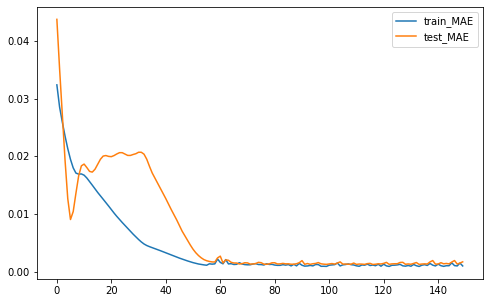

In [8]:
# Design Network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(Dense(1, activation="linear", kernel_constraint=NonNeg()))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit network
# epochs = how long you're running it
# batch_size = number of training samples to use in an epoch
history = model.fit(train_X, train_y, epochs=150, batch_size=450, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.figure(figsize=(8,5))
pyplot.plot(history.history['loss'], label='train_MAE')
pyplot.plot(history.history['val_loss'], label='test_MAE')
pyplot.legend()
pyplot.show()

### Prediction

In [9]:
# make a prediction
yhat = model.predict(predict_X)
predict_X_2D = predict_X.reshape((predict_X.shape[0], predict_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
predict_y = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y, predict_X_2D[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

### Metrics

In [10]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(mean(inv_y))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 20.341
Normalized RMSE: 0.062


In [11]:
# Finding the predicted quarterly maximums
dates = dates[len(dates)-n_predict:]

#maxes = [dates[np.argmax(yhat[0:89], axis=0)]]
#maxes_actual = [dates[np.argmax(predict_y[0:89], axis=0)]]
maxes = [
    dates[np.argmax(yhat[0:89], axis=0)], 
    dates[np.argmax(yhat[90:179], axis=0)+90], 
    dates[np.argmax(yhat[180:269], axis=0)+180], 
    dates[np.argmax(yhat[270:364], axis=0)+270]
]
maxes_actual = [
    dates[np.argmax(predict_y[0:89], axis=0)], 
    dates[np.argmax(predict_y[90:179], axis=0)+90], 
    dates[np.argmax(predict_y[180:269], axis=0)+180], 
    dates[np.argmax(predict_y[270:364], axis=0)+270]
]

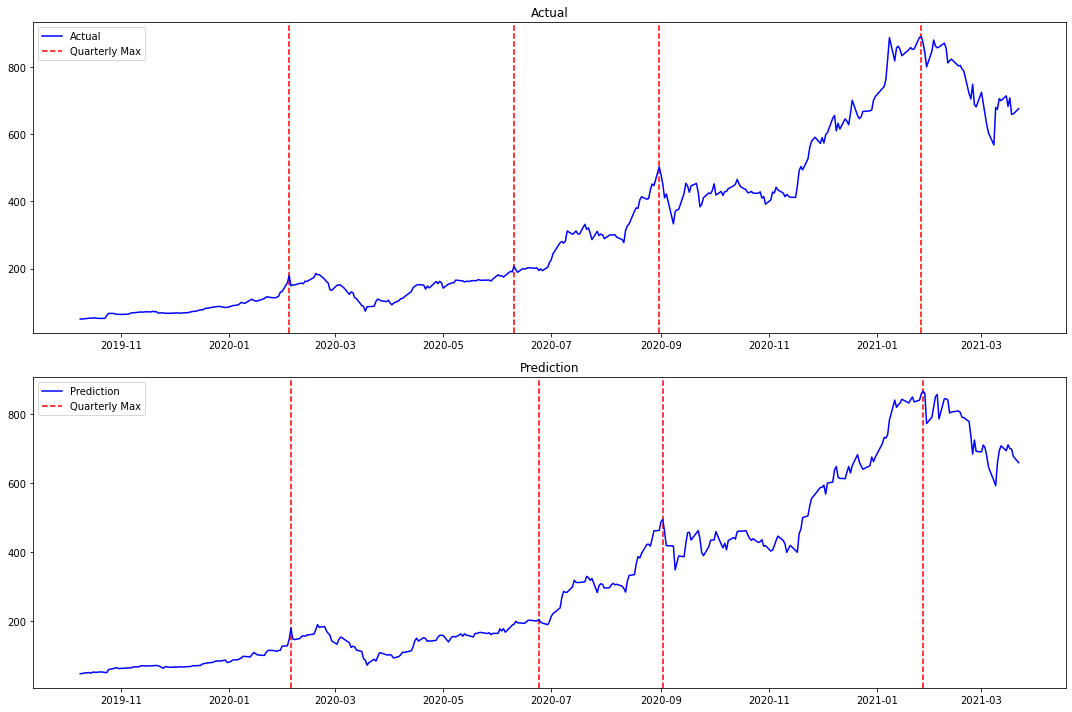

In [12]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(15,10))

pyplot.subplot(2, 1, 1)
pyplot.plot(dates, inv_y, color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual")

pyplot.subplot(2, 1, 2)
pyplot.plot(dates, inv_yhat, color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction")

pyplot.tight_layout()
pyplot.show()

In [13]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i][0]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i][0]))
    print("Diff: %s" %abs((maxes_actual[i][0]-maxes[i][0]).astype('timedelta64[D]')))

Q1 Max: 2020-02-05T00:00:00.000000000
Q1 Actual Max: 2020-02-04T00:00:00.000000000
Diff: 1 days
Q2 Max: 2020-06-24T00:00:00.000000000
Q2 Actual Max: 2020-06-10T00:00:00.000000000
Diff: 14 days
Q3 Max: 2020-09-02T00:00:00.000000000
Q3 Actual Max: 2020-08-31T00:00:00.000000000
Diff: 2 days
Q4 Max: 2021-01-27T00:00:00.000000000
Q4 Actual Max: 2021-01-26T00:00:00.000000000
Diff: 1 days


In [14]:
import shap

# Create explainer for SHAP feature analysis
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(predict_X)
shap.initjs()

# Data has to be converted to 2D
# The "20" here is the number of features in the model
shap_values_2D = shap_values[0].reshape(-1,20)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


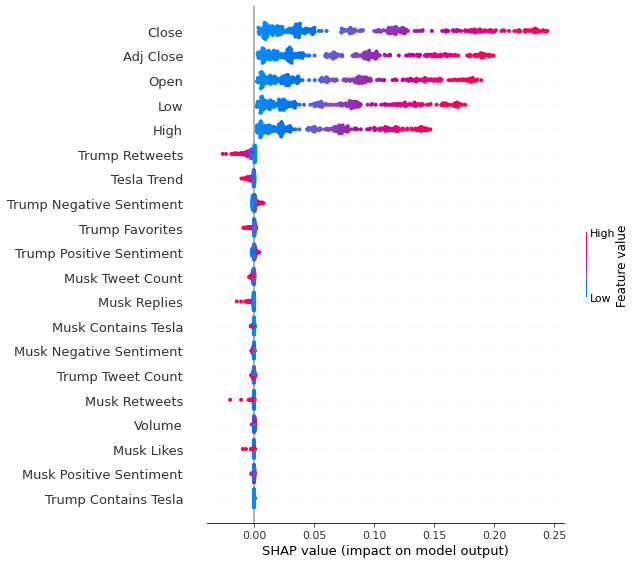

In [15]:
# Plot of Feature Importance
shap.summary_plot(shap_values_2D, features=predict_X_2D, feature_names=df.columns)